In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib as mpl
import pandas as pd
# ^^^ pyforest auto-imports - don't write above this line
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
mpl.rc('figure', max_open_warning = 0)

import chart_studio
import chart_studio.plotly as py
import chart_studio.tools as tls

In [156]:
#read in data
df = pd.read_csv('analysis_data_test.csv', low_memory = False)

In [139]:
#look at general structure of data, no missingness!
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 9 columns):
 #   Column                               Non-Null Count    Dtype  
---  ------                               --------------    -----  
 0   marketing_source                     1048575 non-null  object 
 1   shopper_creation_timestamp_pst       1048575 non-null  object 
 2   shopper_id                           1048575 non-null  int64  
 3   number_calls_answered                1048575 non-null  int64  
 4   number_calls_longer_than_200seconds  1048575 non-null  int64  
 5   partner_revenue                      1048575 non-null  float64
 6   marketing_cost                       1048575 non-null  float64
 7   policies_submitted                   1048575 non-null  int64  
 8   policy_value                         1048575 non-null  float64
dtypes: float64(3), int64(4), object(2)
memory usage: 72.0+ MB


In [157]:
df['shopper_creation_timestamp_pst'] = pd.to_datetime(df['shopper_creation_timestamp_pst'])

In [158]:
df = df.sort_values('shopper_creation_timestamp_pst').reset_index(drop = True)

In [159]:
df.head()

,marketing_source,shopper_creation_timestamp_pst,shopper_id,number_calls_answered,number_calls_longer_than_200seconds,partner_revenue,marketing_cost,policies_submitted,policy_value
0,BI,2018-05-01 00:00:00,4608675,2,1,0.00,7.56,0,0.0
1,AK,2018-05-01 00:00:00,4608680,0,0,5.51,19.00,0,0.0
2,S,2018-05-01 00:00:00,4608679,0,0,0.00,20.56,0,0.0
3,U,2018-05-01 00:01:00,4608681,0,0,0.00,6.67,0,0.0
4,BI,2018-05-01 00:02:00,4608685,1,0,0.00,7.56,0,0.0


In [160]:
#how many unique shoppers did they have? -- oh wow they are all unique, interesting
df.shopper_id.nunique()

1048575

In [161]:
df.marketing_source.nunique()

62

In [162]:
#total spent to acquire customers
cost = sum(df['marketing_cost'])
cost

5756009.740000995

In [163]:
#net value generated from marketing to customers
gain = sum(df['policy_value'] + df['partner_revenue'])
gain

8812448.583001388

In [164]:
#the cost subtracted from gain
gain - cost

3056438.8430003934

In [165]:
#create total revenue column
df['total_revenue'] = df['policy_value'] + df['partner_revenue']

In [166]:
df.head()

,marketing_source,shopper_creation_timestamp_pst,shopper_id,number_calls_answered,number_calls_longer_than_200seconds,partner_revenue,marketing_cost,policies_submitted,policy_value,total_revenue
0,BI,2018-05-01 00:00:00,4608675,2,1,0.00,7.56,0,0.0,0.00
1,AK,2018-05-01 00:00:00,4608680,0,0,5.51,19.00,0,0.0,5.51
2,S,2018-05-01 00:00:00,4608679,0,0,0.00,20.56,0,0.0,0.00
3,U,2018-05-01 00:01:00,4608681,0,0,0.00,6.67,0,0.0,0.00
4,BI,2018-05-01 00:02:00,4608685,1,0,0.00,7.56,0,0.0,0.00


# Correlations
- Some interesting things to note here
    - it appears as though num_calls_answered and calls that lasted longer than 200 seconds are perfectly correlated
    - policy_value and total_revenue are highly correlated with policies_submitted

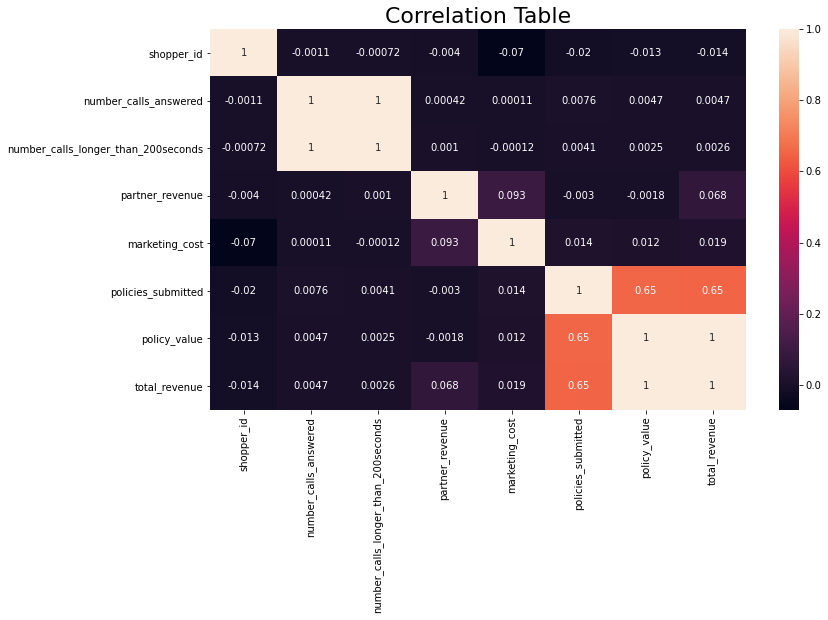

In [37]:
plt.figure(figsize = (12, 7))
sns.heatmap(df.corr(), annot = True)
plt.title('Correlation Table', fontsize = 22);

# Revenue Decrease Coincides With Marketing Spend Decrease in June
- It looks like the marketing team spent less money to acquire customers in June, which coincided with a decrease in total revenue, so they did change something

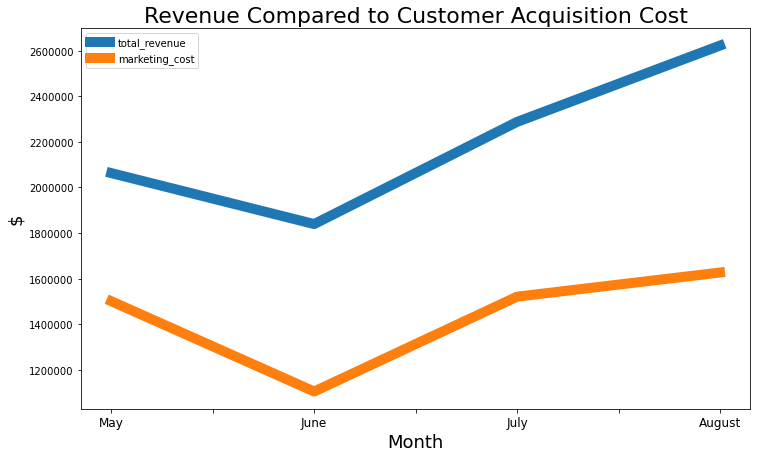

In [258]:
ax = pd.DataFrame(df.groupby([df['shopper_creation_timestamp_pst']\
                         .dt.month]).total_revenue.sum()).plot(figsize = (12, 7), linewidth = 10)
plt.title('Revenue Compared to Customer Acquisition Cost', fontsize = 22)
plt.ylabel('$', fontsize = 18)
ax.set_xticklabels(['', 'May', '', 'June', '', 'July', '', 'August'], fontsize = 12);

df.groupby(df['shopper_creation_timestamp_pst'].dt.month).marketing_cost.sum().plot(figsize = (12, 7), linewidth = 10);

plt.ticklabel_format(style = 'plain', axis = 'y')
plt.xlabel('Month', fontsize = 18)

plt.legend();

# Sales Had Huge Spike in 'Opportunity' Calls in Second Half of June
- I am making the assumption that this must be an outlier/data mistake

In [167]:
#check out the number of calls longer than 200 secs
real_calls = df[df['number_calls_longer_than_200seconds'] != 0]

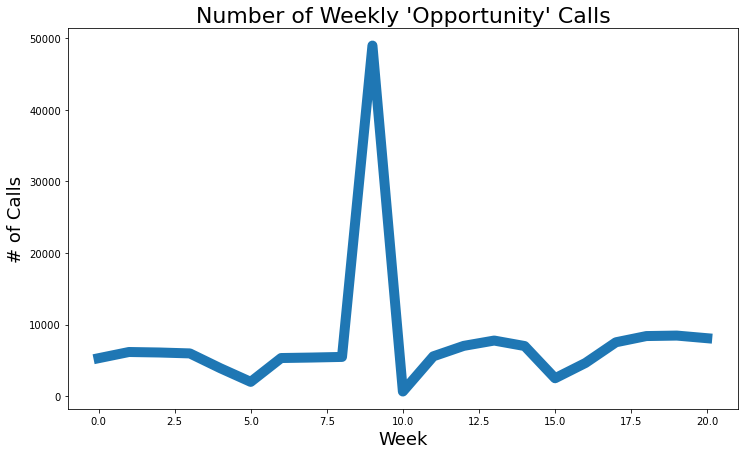

In [197]:
ax = pd.DataFrame(real_calls.groupby([real_calls['shopper_creation_timestamp_pst'].dt.month, real_calls['shopper_creation_timestamp_pst'].dt.week])\
             .number_calls_longer_than_200seconds.sum()).rename(columns = {'number_calls_longer_than_200seconds':'num_calls'}).reset_index(drop = True)\
                        .plot(figsize = (12, 7), linewidth = 10)
plt.title("Number of Weekly 'Opportunity' Calls", fontsize = 22)
plt.ylabel('# of Calls', fontsize = 18)
plt.xlabel('Week', fontsize = 18)
ax.get_legend().remove();

In [169]:
#find the outlier
df['number_calls_longer_than_200seconds'].max()

42917

In [170]:
df[df['number_calls_longer_than_200seconds'] == 42917]

,marketing_source,shopper_creation_timestamp_pst,shopper_id,number_calls_answered,number_calls_longer_than_200seconds,partner_revenue,marketing_cost,policies_submitted,policy_value,total_revenue
379183,Unknown,2018-06-27 09:18:00,5802387,78414,42917,0.0,0.0,0,0.0,0.0


In [176]:
#remove the outlier, re-plot
real_calls_no_outlier = real_calls[real_calls['number_calls_longer_than_200seconds'] != 42917]

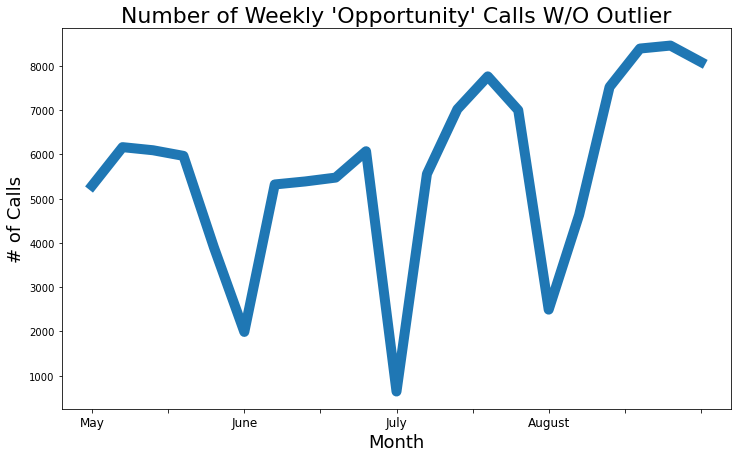

In [248]:
ax = pd.DataFrame(real_calls_no_outlier.groupby([real_calls_no_outlier['shopper_creation_timestamp_pst'].dt.month, real_calls_no_outlier['shopper_creation_timestamp_pst'].dt.week])\
             .number_calls_longer_than_200seconds.sum()).rename(columns = {'number_calls_longer_than_200seconds':'num_calls'}).reset_index(drop = True)\
                        .plot(figsize = (12, 7), linewidth = 10)
plt.title("Number of Weekly 'Opportunity' Calls W/O Outlier", fontsize = 22)
plt.ylabel('# of Calls', fontsize = 18)
plt.xlabel('Month', fontsize = 18)
ax.set_xticklabels(['', 'May', '', 'June', '', 'July', '', 'August'], fontsize = 12);
ax.get_legend().remove();

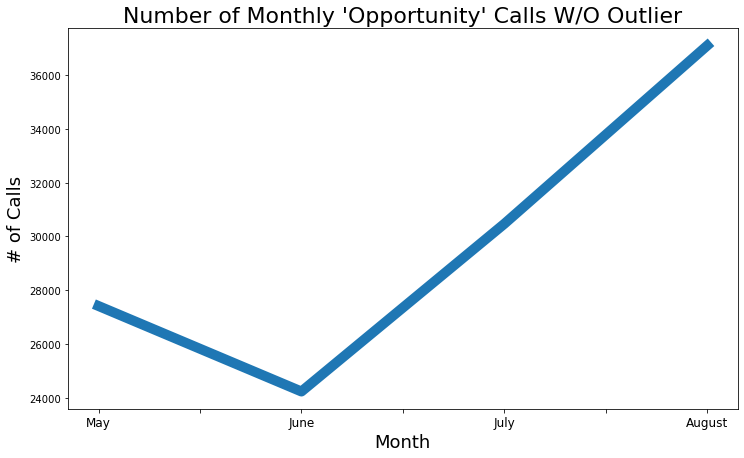

In [256]:
ax = pd.DataFrame(real_calls_no_outlier.groupby([real_calls_no_outlier['shopper_creation_timestamp_pst'].dt.month])\
             .number_calls_longer_than_200seconds.sum()).rename(columns = {'number_calls_longer_than_200seconds':'num_calls'}).reset_index(drop = True)\
                        .plot(figsize = (12, 7), linewidth = 10)
plt.title("Number of Monthly 'Opportunity' Calls W/O Outlier", fontsize = 22)
plt.ylabel('# of Calls', fontsize = 18)
plt.xlabel('Month', fontsize = 18)
ax.set_xticklabels(['', 'May', '', 'June', '', 'July', '', 'August'], fontsize = 12);
ax.get_legend().remove();

# The Number of Policies Sold Decreased in June, Coinciding With Reduced Marketing Spend

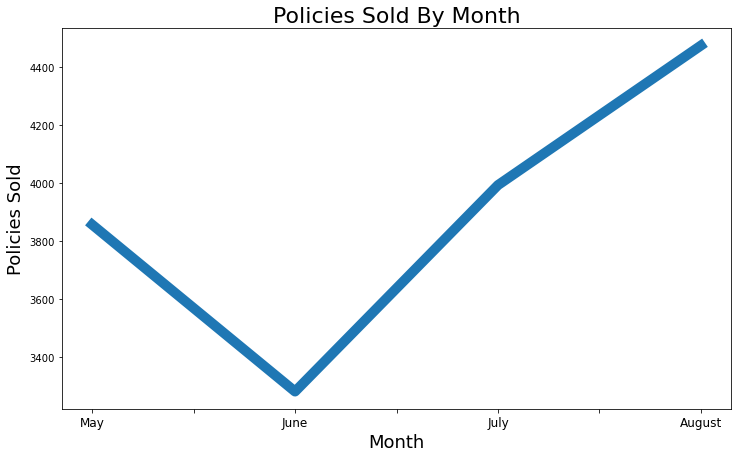

In [257]:
ax = df.groupby(df['shopper_creation_timestamp_pst'].dt.month).policies_submitted.sum().plot(figsize = (12, 7), linewidth = 10)
plt.title('Policies Sold By Month', fontsize = 22)
plt.ylabel('Policies Sold', fontsize = 18)
plt.xlabel('Month', fontsize = 18)
ax.set_xticklabels(['', 'May', '', 'June', '', 'July', '', 'August', ''], fontsize = 12);

# Partner Revenue Almost Doubled During Summer 2018 
- This seems to be happening regardless of marketing spend, but ramps up quickly once marketing spend increases in July and August

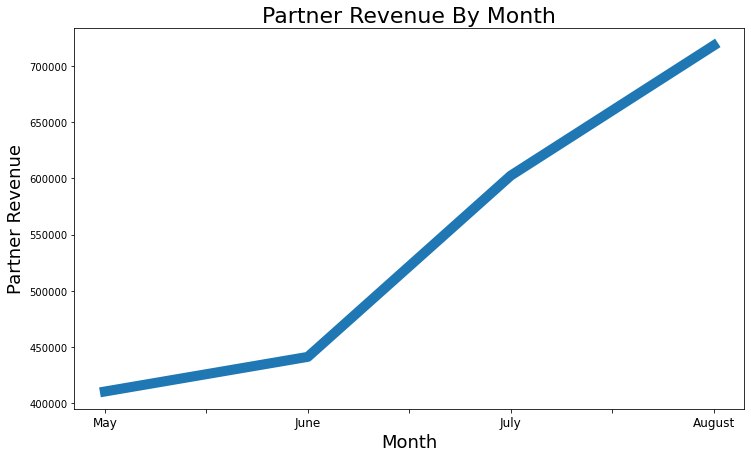

In [259]:
ax = df.groupby(df['shopper_creation_timestamp_pst'].dt.month).partner_revenue.sum().plot(figsize = (12, 7), linewidth = 10)
plt.title('Partner Revenue By Month', fontsize = 22)
plt.ylabel('Partner Revenue', fontsize = 18)
plt.xlabel('Month', fontsize = 18)
ax.set_xticklabels(['', 'May', '', 'June', '', 'July', '', 'August', ''], fontsize = 12);

# Average Marketing Cost Per Source
- are some of the more expensive sources being decreased in June? While cheaper ones increasing?
- __It appears as though when high cost marketing decreases in June, this coincides with lower revenue, while low cost marketing continues to increase. When low cost marketing increases while high cost marketing decreases, overall revenue decreases, but when these both increase at the same time then revenue increases__

In [297]:
top_10_sources = [x for x in 
                  df.groupby('marketing_source').marketing_cost.agg(['mean', 'count']).sort_values('mean', ascending = False).nlargest(10, 'mean').index]

In [298]:
bottom_10_sources = [x for x in 
                     df.groupby('marketing_source').marketing_cost.agg(['mean', 'count']).sort_values('mean', ascending = False).nsmallest(10, 'mean').index]

In [299]:
top_marketing_sources = df[df['marketing_source'].isin(top_10_sources)]
bottom_marketing_sources = df[df['marketing_source'].isin(bottom_10_sources)]

In [300]:
top_marketing_sources = pd.DataFrame(top_marketing_sources.groupby([top_marketing_sources['shopper_creation_timestamp_pst'].dt.month, 'marketing_source']).marketing_source.count())\
.rename(columns = {'marketing_source':'count'}).reset_index()

In [301]:
bottom_marketing_sources = pd.DataFrame(bottom_marketing_sources.groupby([bottom_marketing_sources['shopper_creation_timestamp_pst'].dt.month, 'marketing_source']).marketing_source.count())\
.rename(columns = {'marketing_source':'count'}).reset_index()

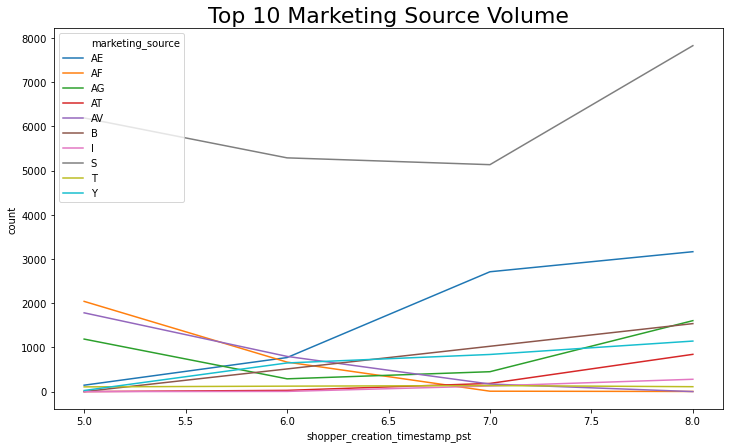

In [302]:
plt.figure(figsize = (12, 7))
sns.lineplot(x = 'shopper_creation_timestamp_pst', y = 'count', data = top_marketing_sources, hue = 'marketing_source')
plt.legend(loc = 'upper left')
plt.title('Top 10 Marketing Source Volume', fontsize = 22);

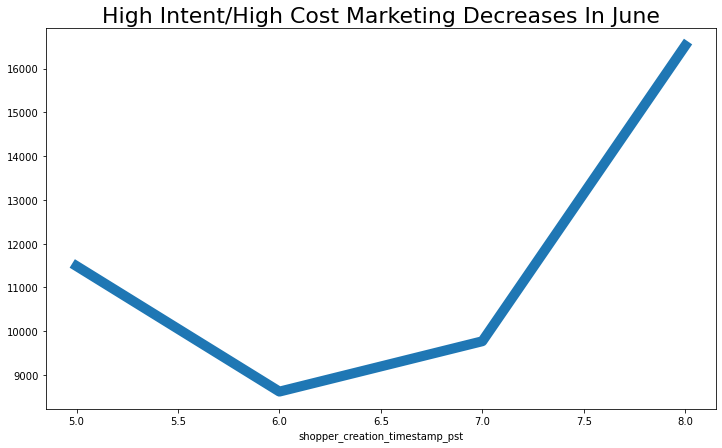

In [308]:
top_marketing_sources.groupby('shopper_creation_timestamp_pst')['count'].sum().plot(figsize = (12, 7), linewidth = 10)
plt.title('High Intent/High Cost Marketing Decreases In June', fontsize = 22);

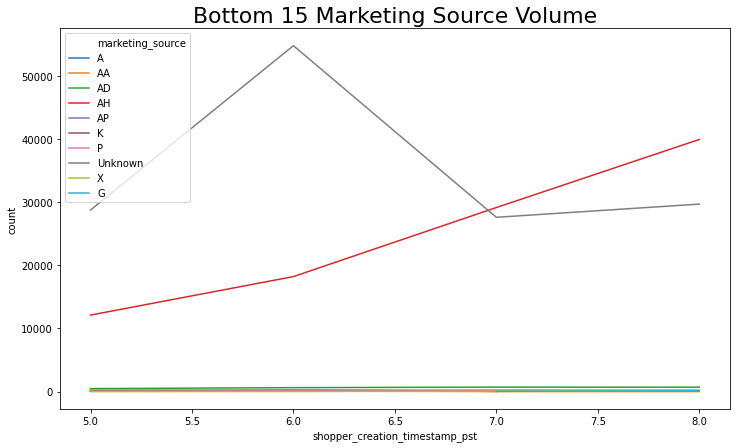

In [304]:
plt.figure(figsize = (12, 7))
sns.lineplot(x = 'shopper_creation_timestamp_pst', y = 'count', data = bottom_marketing_sources, hue = 'marketing_source')
plt.legend(loc = 'upper left')
plt.title('Bottom 15 Marketing Source Volume', fontsize = 22);

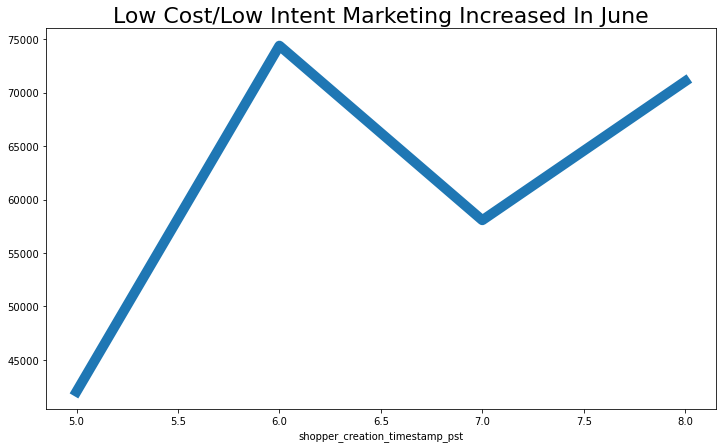

In [307]:
bottom_marketing_sources.groupby('shopper_creation_timestamp_pst')['count'].sum().plot(figsize = (12, 7), linewidth = 10)
plt.title('Low Cost/Low Intent Marketing Increased In June', fontsize = 22);

# Marketing ROI
- While ROI was highest in June, this may have coincided with a decrease in high cost/high intent marketing, which led to a decrease in revenue in June

In [261]:
#create ROI metric column
df['ROI'] = df['total_revenue'] - df['marketing_cost']

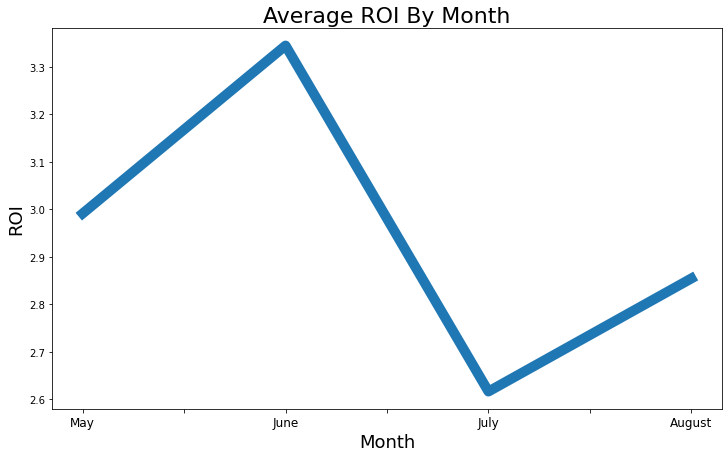

In [271]:
ax = df.groupby(df['shopper_creation_timestamp_pst'].dt.month).ROI.mean().plot(figsize = (12, 7), linewidth = 10) 
plt.title('Average ROI By Month', fontsize = 22)
plt.ylabel('ROI', fontsize = 18)
plt.xlabel('Month', fontsize = 18)
ax.set_xticklabels(['', 'May', '', 'June', '', 'July', '', 'August'], fontsize = 12);